In [1]:
import urllib
import os
import shutil
import urllib.request
import json
import csv
from matplotlib import dates

# Create NPZ Data capsule

C = npz_data(); C.lon=stations[:,0]; C.lat=stations[:,1]; C.station=stations[:,2]
print(type(C))
print(C.VINFO)

In [1]:
#noaa web link
#url0='https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv'
url0 = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date=20230901&end_date=20231001&datum=MSL&station=9411340&time_zone=GMT&units=metric&format=json'

#download and read noaa data
for datum in datums:
    print(datum)
    if not os.path.exists(datum): os.mkdir(datum)
    #download data
    for m,station in enumerate(C.station):
        for year in arange(years[0],years[1]+1):
            url='{}&datum={}&begin_date={}0101&end_date={}1231&station={}'.format(url0,datum.upper(),year,year,int(station))
            print(url)
            fname='{}_{}.csv'.format(int(station),year)
            print(fname)

            if os.path.exists('{}/{}'.format(datum,fname)): continue
            print('download: {}, {}'.format(datum,fname))
            # the try block lets you test a block of code for errors
            # the except block lets you handle the error
            try:
                urllib.request.urlretrieve(url,'{}/{}'.format(datum,fname))
            except:
                # the pass statement is a null statement, a placeholder for future code
                pass

#read data
    fnames=os.listdir('{}'.format(datum));
    #read each file in years
    mtime=[]; station=[]; elev=[]; iflag=0
    for fname in fnames:
        if not fname.endswith('.csv'): continue
        # A RegularExpression (RE) is a special text string used for describing a search pattern
        R=re.match('(\d+)_(\d+).csv',fname); sta=int(R.groups()[0]); year=int(R.groups()[1])

        #read data
        iflag=iflag+1; print('reading {}, {}'.format(fname,iflag))
        fid=open('{}/{}'.format(datum,fname),'r'); lines=fid.readlines(); fid.close(); lines=lines[1:]
        if len(lines)<10: continue

        #parse each line
        for i in arange(len(lines)):
            line=lines[i].split(',')
            if line[1]=='': continue
            #print(line[0])
            doyi=dates.datestr2num(line[0]); elevi=float(line[1])

            #save record
            mtime.append(doyi)
            station.append(sta)
            elev.append(elevi)
#-save data-------
    S=npz_data(); S.time=array(mtime); S.elev=array(elev)
    S.station=array(station).astype('int')

    # add lat&lon information
    Lat=dict(zip(C.station,C.lat)); Lon=dict(zip(C.station,C.lon))
    S.lat=array([Lat[i] for i in S.station])
    S.lon=array([Lon[i] for i in S.station])
    save_npz('noaa_elev_{}'.format(datum),S)

Distance from Santa Barbara to Monterey, CA: 195.76 miles
Stat Calcs MSL
Santa Barbara Mean: 0.147 m
Monterey Mean: 0.142 m
Santa Barbara SD: 0.49 m
Monterey SD: 0.47 m


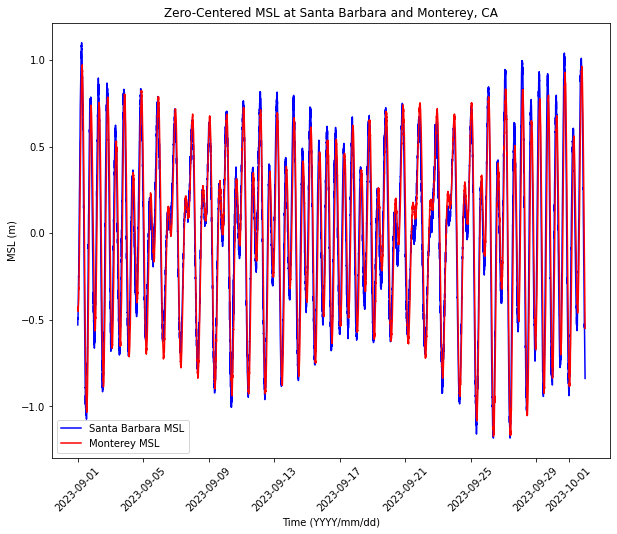

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylib import *
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import skew
from matplotlib.offsetbox import AnchoredText

# If needed, run this in your folder

#/opt/homebrew/opt/python@3.8/bin/python3.8 -m pip install git+https://github.com/moflaher/ttide_py.git

import ttide as tt
#from ttide import *
#!pip install ttide

#!pip install folium
#!pip install geopy

import folium
from geopy.distance import geodesic

# Santa Barbara, CA - Station ID: 9411340 ----- 0
# Monterey, CA - Station ID: 9413450 ------- 1
# metric, GMT, MSL, csv, 6-minute intervals

file_loc = ['/Users/kboothomefolder/phy577_projects/hw5/data/CO-OPS__9411340.csv','/Users/kboothomefolder/phy577_projects/hw5/data/CO-OPS__9413450.csv']
stas = [pd.read_csv(file) for file in file_loc]

stas[0], stas[1] = pd.DataFrame(stas[0].iloc[:, :-5]), pd.DataFrame(stas[1].iloc[:, :-5])

################# Create Dataframe ##########################
#print(stas[0].columns)

# Convert "Date Time" column to numpy datetime64 array

for i in range(len(stas)):
    stas[i]['datestr'] = np.asarray(pd.to_datetime(stas[i]['Date Time']))
    stas[i]['msl'] = np.asarray(pd.to_numeric(stas[i][' Water Level']))
    stas[i]['sigma'] = np.asarray(pd.to_numeric(stas[i][' Sigma']))
    stas[i].drop(stas[i].columns[0:3], axis=1, inplace=True)
    stas[i]['zero'] = np.asarray(stas[i]['msl'] - mean(stas[i]['msl'])) # Remove the sample mean 


    
################# Plot Locations on Map w/ distance ##########################

SB_coords = (34.405 , -119.6917)
M_coords = (36.6002, -121.8947)

# Calculate distance between the two locations
dist = geodesic(SB_coords, M_coords).miles

# Create a folium map centered between the two locations
m = folium.Map(location=[(SB_coords[0] + M_coords[0]) / 2, (SB_coords[1] + M_coords[1]) / 2], zoom_start=6)

# Add markers for Santa Barbara and Monterey
folium.Marker(SB_coords, tooltip="Santa Barbara, CA").add_to(m)
folium.Marker(M_coords, tooltip="Monterey, CA").add_to(m)

# Create a line between the two locations to show the distance
line = folium.PolyLine([SB_coords, M_coords], color='blue', weight=2, opacity=1)
line.add_to(m)

# Display the distance as a tooltip on the line
line.add_child(folium.Tooltip(f"Distance: {dist:.2f} miles"))

output_dir = '/Users/kboothomefolder/phy577_projects/hw5/figures'
m.save(os.path.join(output_dir, 'SB_M_map.html'))

print("Distance from Santa Barbara to Monterey, CA:", round(dist, 2), "miles")
################# Plot MSL ##########################
'''
plt.figure(figsize=(10, 8))
plt.plot(stas[0]['datestr'].values, stas[0]['msl'].values, color='blue', label='Santa Barbara MSL')
plt.plot(stas[1]['datestr'].values, stas[1]['msl'].values, color='red', label='Monterey MSL')
plt.xlabel('Time (YYYY/mm/dd)')
plt.ylabel('MSL (m)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Mean Sea Level at Santa Barbara and Monterey, CA')

output_dir = '/Users/kboothomefolder/phy577_projects/hw5/figures'
plt.savefig(os.path.join(output_dir, 'MSL_SB_M.png'))
'''
######################## Calculate Statistics ##########################

m0 = round(np.mean(stas[0]['msl']), 3) # sample mean
m1 = round(np.mean(stas[1]['msl']), 3) # sample mean

stdev0 = round(np.std(stas[0]['msl']),2) # standard deviation
stdev1 = round(np.std(stas[1]['msl']),2) # standard deviation

skew0 = round(skew(stas[0]['msl']),3) # skewness
skew1 = round(skew(stas[1]['msl']),3) # skewness

var0 = round(var(stas[0]['msl']),3)
var1 = round(var(stas[1]['msl']),3)

print("Stat Calcs MSL")
print("Santa Barbara Mean:", m0, "m")
print("Monterey Mean:", m1, "m")

print("Santa Barbara SD:", stdev0, "m")
print("Monterey SD:", stdev1, "m")

#print("Santa Barbara Skew:", skew0, "m")
#print("Monterey Skew:", skew1, "m")

plt.figure(figsize=(10, 8))
plt.plot(stas[0]['datestr'].values, stas[0]['zero'].values, color='blue', label='Santa Barbara MSL')
plt.plot(stas[1]['datestr'].values, stas[1]['zero'].values, color='red', label='Monterey MSL')
plt.xlabel('Time (YYYY/mm/dd)')
plt.ylabel('MSL (m)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Zero-Centered MSL at Santa Barbara and Monterey, CA')

output_dir = '/Users/kboothomefolder/phy577_projects/hw5/figures'
plt.savefig(os.path.join(output_dir, 'ZeroMSL_SB_M.png'))


In [8]:
'''

######################################## Run ttide package ##############################################3
from datetime import datetime
import matplotlib.dates as mdates

# Run for Santa Barbara --> stas[0]

dt = 0.10 # 6 minute interval 
msl0 = np.array(stas[0]['zero']) # convert mean sea level to np.array
t = stas[0]['datestr'][0]
t0 = mdates.date2num(t)


print(t0.dtype) # np array
print(msl0.dtype) # np array

tide0 = tt.t_tide(msl0, dt=0.10, stime=t0, lat=None)

# There was an issue wiht t_astron.py (needed to edit to math.fmod instead of np.fmod in original file b/c wrong package referenced)

'''

float64
float64


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
#import math

#example

#math.fmod(-17, 5)

In [ ]:
'''
def t_tide(xin, dt=1, stime=None, lat=None,
           out_style='classic',
           outfile=None,
           corr_fs=[0, 1e6], corr_fac=[1, 1],
           secular='mean',
           infiname=[], infirefname=[],
           ray=1,
           shallownames=[], constitnames=[],
           errcalc='cboot', synth=2,
           lsq='best'):
    """T_TIDE Harmonic analysis of a time series.

    Parameters
    ----------
    xin : array_like
       can be real (e.g. for elevations), or complex (U + 1j * V)
       for eastward velocity U and northward velocity V.

    dt : float
       Sampling interval in hours, default = 1.

    stime : float (mpl_datenum) or python datetime
       The start time of the series, in matplotlib_datenum format (default empty).

    lat : float
       decimal degrees (+north) (default: none).

    out_style : {None, 'classic', 'pandas'}
       where to send printed output
         None      - no printed output
         'classic' - to screen in classic-mode (default)
         'pandas'  - to screen in pandas-like mode.

    outfile : str or None
       The filename to write to (default: None, do not write to a
       file). This writes in format `out_style` ('classic' if
       `out_style` is None).

    corr_fs : array_like
        frequencies of the pre-filter transfer function (see note on
        pre-filtering)
    corr_fac : array_like (possible complex)
        correction factor magnitudes (see note on pre-filtering)

    secular : {'mean', 'linear'}
      Adjustment for long-term behavior ("secular" behavior).
           'mean'    - assume constant offset (default).
           'linear'  - get linear trend.

    infiname : list-like of names of consituents to be inferred
        Unclear what a more specific docstring should be. Clarify docs here.

    infirefname : list-like of names of references
        Unclear what a more specific docstring should be. Clarify docs here.

    ray : float
        The Rayleigh criteria (default: 1)

    shallownames : list-like of strings
        The names of shallow-water constituents to analyze.

    errcalc : string
        Method to use for calculation of confidence limits:
            'wboot' - Boostrapped confidence intervals based on a
                      correlated bivariate white-noise model.
            'cboot' - Boostrapped confidence intervals based on an
                      uncorrelated bivariate coloured-noise model
                      (default).'
           'linear' - Linearized error analysis that assumes an
                      uncorrelated bivariate coloured noise model.

    synth : float
        The signal-to-noise ratio of constituents to use for the
        "predicted" tide (passed to t_predic, but note that the
        default value is different).
            0 - use all selected constituents
           >0 - use only those constituents with a SNR greater than
                that given (1 or 2 are good choices, 2 is the
                default).
           <0 - return result of least-squares fit (should be the same
                as using '0', except that NaN-holes in original time
                series will remain and mean/trend are included).

    lsq : string
        'direct'  - use A\ x fit
        'normal'  - use (A'A)\(A'x) (may be necessary for very large
                  input vectors since A'A is much smaller than A)
          'best'  - automatically choose based on length of series
                  (default).
'''

In [ ]:
######################################## Cut Code #################################################

In [ ]:
# Check variable types and NaNs

'''
print(type(time[0])) # type datetime64
print(type(MSL[0])) # type float64
print(type(Sigma[0])) # type float64


# Data obs v NaN calculations

#How many obervations? Same for each category due to timeframe
obs = len(MSL) # 38,938 obs
      
#Determine how many observations are not Nan
nan = np.asarray(len(MSL[np.isnan(MSL)]))

valid_obs = (obs - nan)/obs * 100 # 100% legit values

print(valid_obs) 
'''